## Create helper functions

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view');"
    return run_query(q)
     
show_tables()  


,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting albums to purchase

In [2]:
# increase data to graphics ratio on plot        

q1 ="""
    WITH sales_usa AS
    (
        SELECT
            il.* FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
        WHERE c.country = 'USA'
    )
    SELECT 
        g.name genre,
         COUNT(su.invoice_line_id) tracks_purchased, 
        (CAST(COUNT(su.track_id) AS FLOAT) * 100/(SELECT COUNT(*) FROM sales_usa)) percentage_sold
    FROM sales_usa su
    INNER JOIN track t ON t.track_id = su.track_id
    INNER JOIN genre g ON g.genre_id = t.genre_id
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 8;
    """
run_query(q1)

,genre,tracks_purchased,percentage_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245


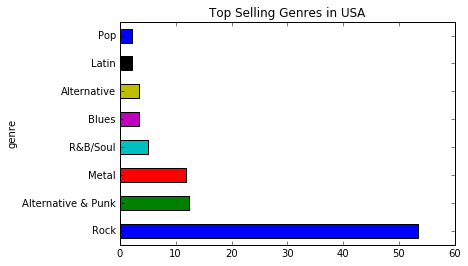

In [3]:
genre_sales_usa = run_query(q1)
genre_sales_usa.set_index("genre", drop=True, inplace=True)
genre_sales_usa["percentage_sold"].plot.barh(title="Top Selling Genres in USA")
plt.show()

### Findings
The graphs shows that the top three(3) genres are Rock (53%), Alternative & Punk (12%) and Metal(11.8%) with Rock doing considerably better than any other genre. If our decision is to be informed by the data then we should purchase Red Tone, Slim Jim Blues and Meteor and the Girls for the store.

## Analyzing Employee Sales Performance

   employee_name        date  total_sales
0  Steve Johnson  2017-10-17      1393.92
1  Margaret Park  2017-05-03      1584.00
2   Jane Peacock  2017-04-01      1731.51


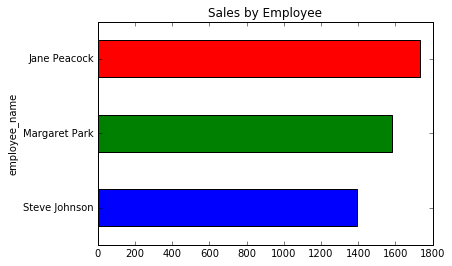

In [4]:
import numpy as np
# increase data to graphics ratio on plot        
q2 = """
    SELECT 
        e.employee_name,
        date(e.hire_date) as date,
        SUM(i.total) total_sales
    FROM invoice i
    INNER JOIN customer c
    ON c.customer_id = i.customer_id
    INNER JOIN 
        (
            SELECT
                employee_id, 
                first_name ||" "|| last_name employee_name, 
                hire_date 
                FROM employee
        ) e
    ON e.employee_id = c.support_rep_id
    GROUP BY 1
    ORDER BY 2 DESC;
    """
run_query(q2)
employee_sales = run_query(q2)
print(employee_sales)
employee_sales.set_index("employee_name",drop=True, inplace=True)
employee_sales["total_sales"].plot.barh(legend=False, title="Sales by Employee")
plt.show()


### Interpretation:
Jame Peacock has made the highest total dollar sales. Considertion of the chart suggests that the number of sales is based on length of time employee is at the store. 

## Analyzing Sales by Country

In [5]:
# Total orders should not be equal to total number of customers 
# because there are customers who placed more than one order
#rewrite code from scratch: do country grouping first

q="""

WITH 
    country_sales AS
        ( 
            SELECT
                CASE
                   WHEN (
                         SELECT count(*)
                         FROM customer
                         where country = c.country
                        ) = 1 THEN "Other"
                   ELSE c.country
                END AS country,
               c.customer_id,
               il.*
            FROM invoice_line il
            INNER JOIN invoice i ON i.invoice_id = il.invoice_id
            INNER JOIN customer c ON c.customer_id = i.customer_id
        ),
    country_calc AS
        (
            SELECT
                country,
                count(distinct customer_id) total_customers,
                SUM(unit_price) total_sales,
                ROUND(SUM(unit_price) / count(distinct invoice_id),1) average_order,
                ROUND(SUM(unit_price) / count(distinct customer_id), 1) avg_sales_per_customer,
                CASE
                    WHEN country = "Other" THEN 1
                    ELSE 0
                END AS sort
            FROM country_sales
            GROUP BY country
            ORDER BY sort ASC, total_sales DESC
        )
SELECT
    country,
    total_customers,
    total_sales,
    average_order,
    avg_sales_per_customer
FROM country_calc

    """

run_query(q)

,country,total_customers,total_sales,average_order,avg_sales_per_customer
0,USA,13,1040.49,7.9,80.0
1,Canada,8,535.59,7.0,66.9
2,Brazil,5,427.68,7.0,85.5
3,France,5,389.07,7.8,77.8
4,Germany,4,334.62,8.2,83.7
5,Czech Republic,2,273.24,9.1,136.6
6,United Kingdom,3,245.52,8.8,81.8
7,Portugal,2,185.13,6.4,92.6
8,India,2,183.15,8.7,91.6
9,Other,15,1094.94,7.4,73.0


   ## Visualizing Sales by Country  

          country  total_customers  total_sales  average_order  \
0             USA               13      1040.49            7.9   
1          Canada                8       535.59            7.0   
2          Brazil                5       427.68            7.0   
3          France                5       389.07            7.8   
4         Germany                4       334.62            8.2   
5  Czech Republic                2       273.24            9.1   
6  United Kingdom                3       245.52            8.8   
7        Portugal                2       185.13            6.4   
8           India                2       183.15            8.7   
9           Other               15      1094.94            7.4   

   avg_sales_per_customer  
0                    80.0  
1                    66.9  
2                    85.5  
3                    77.8  
4                    83.7  
5                   136.6  
6                    81.8  
7                    92.6  
8                    

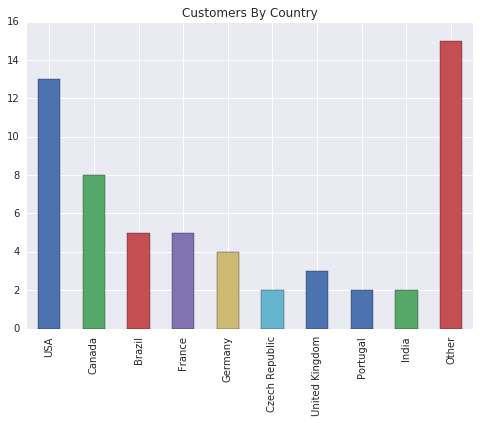

In [6]:
#plots glorious plots
import seaborn as sns
sales_country = run_query(q)
print(sales_country)
sales_country.set_index("country", drop=True, inplace=True)
#x = sales_country["country"]
#y = sales_country["total_customers"]
sales_country["total_customers"].plot.bar(title='Customers By Country')
plt.xlabel('')
plt.show()



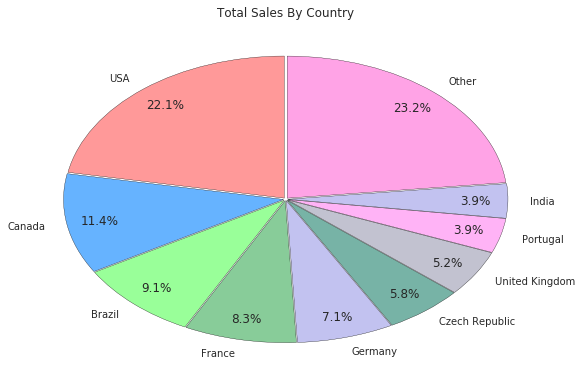

In [7]:
sales_country = run_query(q)
# Pie chart
labels = sales_country['country']
sizes = sales_country['total_sales']
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#88cc99', '#c2c2f0','#77b3a6', '#c2c2d0','#ffb3f6', '#c2c2f0','#ffa3e6']
#explsion
explode = (0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01)
 
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.74,fc='white')
fig = plt.gcf()
#fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Total Sales By Country')
plt.tight_layout()
plt.show()

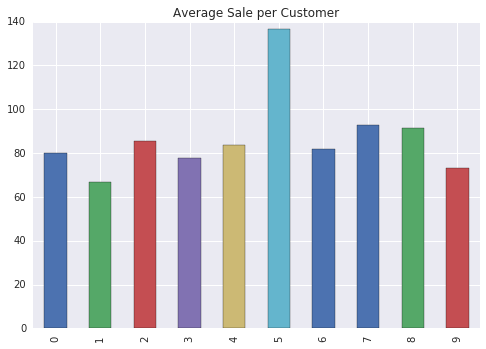

In [28]:
sales_country["avg_sales_per_customer"].plot.bar(title='Average Sale per Customer')
plt.xlabel('')
plt.show()